In [1]:
import abjad
%load_ext abjad.ext.ipython

## Introduction to Object Orientation
Almost all complex projects created with Abjad dependn on a custom set of music-generating classes, and its essential to understand object-oriented programming to begin scaling your ideas into complex musical projects.

Procedural code views the world as a collection of verbs (actions): procedural code passes data into functions and functions pass altered data out to other functions, until the desired result has been achieved. 

Object-oriented programming, on the other hand, views the world as a collection of nouns (objects) that act in an environment. The objects have both characteristics (attributes) and characteristic behaviors (methods).

In this notebook, we're going to take our procedural code from the previous notebook and turn our functions into the characteristic behaviors (methods) of a music-generating class.

## 1. The Class Definition
Now we'll define a `MusicMaker()` class. When we create an instance of this class by calling the class's initializer (`my_musicmaker = MusicMaker(counts, denoms, pitches)`), the class instance will be able to do the four characteristic behaviors we've given it (make basic rhythms, chop at meter, paint on pitches, and add compositional detail, not to mention use these all together in a `make_music()` method):

In [32]:
class MusicMaker(object):

    def __init__(
        self, 
        counts, 
        denominator, 
        pitches,
        clef='treble',
        ):
        self.counts = counts
        self.denominator = denominator
        self.pitches = pitches
        self.clef = abjad.Clef(clef)

    def make_basic_rhythm(self, time_signature_pairs, counts, denominator):
        # THIS IS HOW WE MAKE THE BASIC RHYTHM
        total_duration = sum(
            abjad.Duration(pair) for pair in time_signature_pairs
            )
        talea = abjad.rhythmmakertools.Talea(
            counts=counts,
            denominator=denominator,
            )
        talea_index = 0
        all_leaves = []
        current_duration = abjad.Duration(0)
        while current_duration < total_duration:
            leaf_duration = talea[talea_index]
            if leaf_duration > 0:
                pitch = abjad.NamedPitch("c'")
            else:
                pitch = None
            leaf_duration = abs(leaf_duration)
            if (leaf_duration + current_duration) > total_duration:
                leaf_duration = total_duration - current_duration
            current_leaves = abjad.LeafMaker()([pitch], [leaf_duration])  
            all_leaves.extend(current_leaves)
            current_duration += leaf_duration
            talea_index += 1
        music = abjad.Container(all_leaves) 
        return music


    def clean_up_rhythm(self, music, time_signature_pairs):
        # THIS IS HOW WE CLEAN UP THE RHYTHM
        shards = abjad.mutate(music[:]).split(time_signature_pairs)
        for i, shard in enumerate(shards):
            measure = abjad.Measure(time_signature_pairs[i])
            abjad.mutate(shard).wrap(measure)
        return music
            

    def add_pitches(self, music, pitches):
        # THIS IS HOW WE ADD PITCHES
        pitches = abjad.CyclicTuple(pitches)
        logical_ties = abjad.iterate(music).by_logical_tie(pitched=True)
        for i, logical_tie in enumerate(logical_ties):
            pitch = pitches[i]
            for note in logical_tie:
                note.written_pitch = pitch
        return music


    def add_attachments(self, music):
        # THIS IS HOW WE ADD DYNAMICS AND ACCENTS
        for run in abjad.select(music).by_leaf().by_run(
            (abjad.Note, abjad.Chord)):
            abjad.attach(abjad.Articulation('accent'), run[0])
            if 1 < len(run):
                abjad.attach(abjad.Hairpin('p < f'), run)
            else:
                abjad.attach(abjad.Dynamic('ppp'), run[0])
        return music


    def make_music(self, time_signature_pairs):
        music = self.make_basic_rhythm(
            time_signature_pairs,
            self.counts,
            self.denominator,
            )
        music = self.clean_up_rhythm(music, time_signature_pairs)
        music = self.add_pitches(music, self.pitches)
        music = self.add_attachments(music)
        return music

## 2. Instantiating a Class Instance with the Class Initlalizer Function
We can now create an instance of our `MusicMaker()` class by calling our class initializer. Note that we need to pass in counts, denominators, and pitches to the initializer function, as specified in the `__init__` method of our class definition.

In [33]:
my_musicmaker = MusicMaker(counts, denominator, pitches)

Finally, we can call our maker's `make_music` method to generate music. Note that we need to pass in our time signature pairs, as we specified in the class definition:

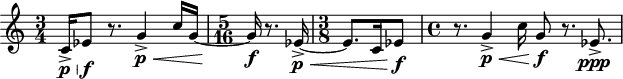

In [34]:
music = my_musicmaker.make_music(time_signature_pairs)
abjad.show(music)

## 3. Creating Varied Musical Textures with Multiple Instances of One Class
Because we can create multiple, variously initialized instances of the same class, it's possible to create both minimal and varied a polyphonic textures with just a single class definition. First, we pass different sets of initializers into a few different instances of our class.

In [35]:
fast_music_maker = MusicMaker(
    counts=[1, 1, 1, 1, 1, -1],
    denominator=16,
    pitches=[0, 1],
    )
slow_music_maker = MusicMaker(
    counts=[3, 4, 5, -1],
    denominator=4,
    pitches=["b,", "bf,", "gf,"],
    clef='bass',
    )
stuttering_music_maker = MusicMaker(
    counts=[1, 1, -7],
    denominator=16,
    pitches=[23],
    ) 
sparkling_music_maker = MusicMaker(
    counts=[1, -5, 1, -9, 1, -5],
    denominator=16,
    pitches=[38, 39, 40],
    clef='treble^8',
    )

Let's use these four musicmakers to create a duo. We can set up a score with two staves and generate the music according to a single set of time signatures:

In [36]:
upper_staff = abjad.Staff()
lower_staff = abjad.Staff()
time_signature_pairs = [(3, 4), (5, 16), (3, 8), (4, 4)]

Next, we iterate through a list of makers, allowing each to generate music that adds up to and fits inside the succession of time signatures, and append the music to our staves. We'll generate music for the top and bottom staff independently, but it's possible to create a musicmaker that outputs music for multiple staves simultaneously (as, for example, a list of selections, one per staff).

In [37]:
for music_maker in ( # in itereation, each differently configured music maker gets assigned to the name "music_maker"
    fast_music_maker,
    slow_music_maker,
    stuttering_music_maker,
    sparkling_music_maker,
    ):
    music = music_maker.make_music(time_signature_pairs) # the current music_maker generates music
    upper_staff.append(music) # add the generated music to the staff

for music_maker in ( # repeat above for lower staff
    slow_music_maker,
    slow_music_maker,
    stuttering_music_maker,
    fast_music_maker,
    ):
    music = music_maker.make_music(time_signature_pairs)
    lower_staff.append(music)


## 5. Score Construction
To construct the final score, we add our two staves to a `PianoStaff()`, add the `PianoStaff()` to a `Score()`, and we can add a final barline to our score.

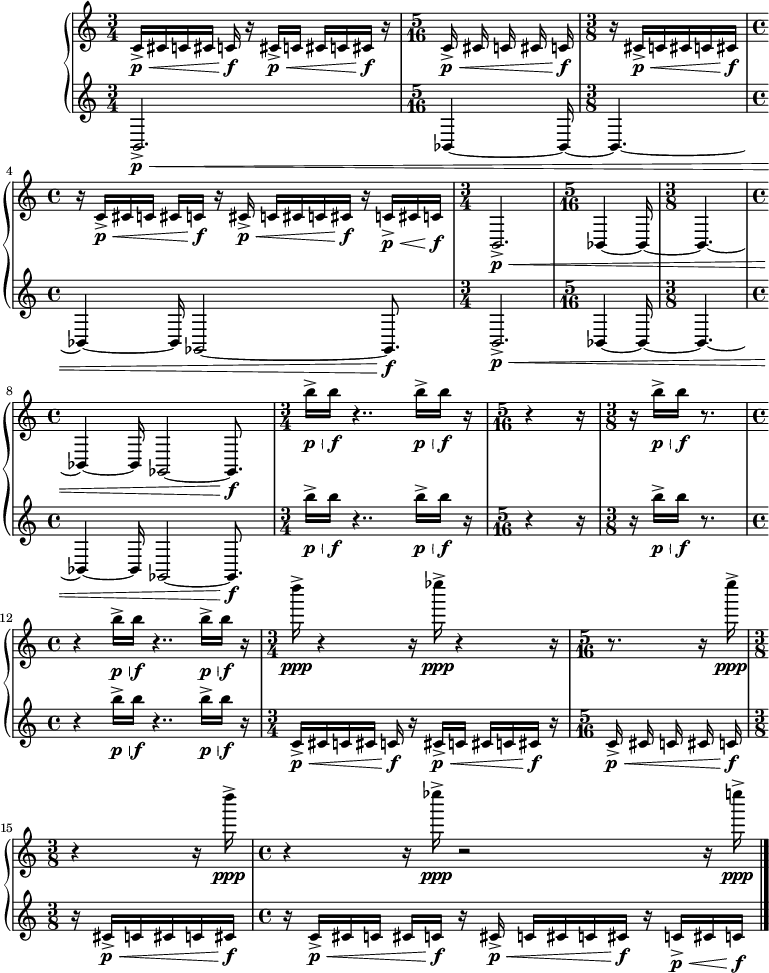

In [42]:
piano_staff = abjad.StaffGroup(context_name='PianoStaff')
piano_staff.extend([upper_staff, lower_staff])

score = abjad.Score([piano_staff])
score.add_final_bar_line()
abjad.show(score)

And we can also play our score back:

In [43]:
abjad.play(score)

<audio controls type="audio/ogg" src="data:audio/ogg;base64,T2dnUwACAAAAAAAAAACNerk1AAAAANaPyQsBHgF2b3JiaXMAAAAAAkSsAAD/////APQBAP////+4AU9nZ1MAAIAAAAAAAAAAjXq5NQEAAABH5f8uFGH/////////////////////PDw7A3ZvcmJpcywAAABYaXBoLk9yZyBsaWJWb3JiaXMgSSAyMDE1MDEwNSAo4puE4puE4puE4puEKQEAAAAhAAAATE9DQVRJT049L3RtcC90bXBoOXozOGcwZS9vdXQub2dnAQV2b3JiaXMpQkNWAQAIAACAIkwYxIDQkFUAABAAAKCsN5Z7yL333nuBqEcUe4i9995746xH0HqIuffee+69pxp7y7333nMgNGQVAAAEAIApCJpy4ELqvfceGeYRURoqx733HhmFiTCUGYU9ldpa6yGT3ELqPeceCA1ZBQAAAgBACCGEFFJIIYUUUkghhRRSSCmlmGKKKaaYYsoppxxzzDHHIIMOOuikk1BCCSmkUEoqqaSUUkot1lpz7r0H3XPvQfgghBBCCCGEEEIIIYQQQghCQ1YBACAAAARCCCFkEEIIIYQUUkghpphiyimngNCQVQAAIACAAAAAAEmRFMuxHM3RHM3xHM8RJVESJdEyLdNSNVMzPVVURdVUVVdVXV13bdV2bdWWbddWbdV2bdVWbVm2bdu2bdu2bdu2bdu2bdu2bSA0ZBUAIAEAoCM5kiMpkiIpkuM4kgSEhqwCAGQAAAQAoCiK4ziO5EiOJWmSZnmWZ4maqJma6KmeCoSGrAIAAAEABAAAAAAA4HiK53iOZ3mS53iOZ3map2mapmmapmmapmmapmmapmmapmmapmmapmmapmmapmmapmmapmmapmmapmlAaMgqAEACAEDHcRzHcRzHcRxHciQHCA1ZBQDIAAAIAEBSJMdyLEdzNMdzPEd0RMd0TMmUVMm1XAsIDVkFAAACAAgAAAAAAEATLEVTPMeTPM8TNc/TNM0TTVE0TdM0TdM0TdM0TdM0TdM0TdM0TdM0TdM0TdM0TdM0TdM0TdM0TVMUgdCQVQAABAAAIZ1mlmqACDOQYSA0ZBUAgAAAABihCEMMCA1ZBQAABAAAiKHkIJrQmvPNOQ6a5aCpFJvTwYlUmye5qZibc84555xszhnjnHPOKcqZxaCZ0JpzzkkMmqWgmdCac855EpsHranSmnPOGeecDsYZYZxzzmnSmgep2Vibc85Z0JrmqLkUm3POiZSbJ7W5VJtzzjnnnHPOOeecc86pXpzOwTnhnHPOidqba7kJXZxzzvlknO7NCeGcc84555xzzjnnnHPOCUJDVgEAQAAABGHYGMadgiB9jgZiFCGmIZMedI8Ok6AxyCmkHo2ORkqpg1BSGSeldILQkFUAACAAAIQQUkghhRRSSCGFFFJIIYYYYoghp5xyCiqopJKKKsoos8wyyyyzzDLLrMPOOuuwwxBDDDG00kosNdVWY4215p5zrjlIa6W11lorpZRSSimlIDRkFQAAAgBAIGSQQQYZhRRSSCGGmHLKKaegggoIDVkFAAACAAgAAADwJM8RHdERHdERHdERHdERHc/xHFESJVESJdEyLVMzPVVUVVd2bVmXddu3hV3Ydd/Xfd/XjV8XhmVZlmVZlmVZlmVZlmVZlmUJQkNWAQAgAAAAQgghhBRSSCGFlGKMMcecg05CCYHQkFUAACAAgAAAAABHcRTHkRzJkSRLsiRN0izN8jRP8zTRE0VRNE1TFV3RFXXTFmVTNl3TNWXTVWXVdmXZtmVbt31Ztn3f933f933f933f933f13UgNGQVACABAKAjOZIiKZIiOY7jSJIEhIasAgBkAAAEAKAojuI4jiNJkiRZkiZ5lmeJmqmZnumpogqEhqwCAAABAAQAAAAAAKBoiqeYiqeIiueIjiiJlmmJmqq5omzKruu6ruu6ruu6ruu6ruu6ruu6ruu6ruu6ruu6ruu6ruu6ruu6QGjIKgBAAgBAR3IkR3IkRVIkRXIkBwgNWQUAyAAACADAMRxDUiTHsixN8zRP8zTREz3RMz1VdEUXCA1ZBQAAAgAIAAAAAADAkAxLsRzN0SRRUi3VUjXVUi1VVD1VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVXVNE3TNIHQkJUAABkAAMO05NJyz42gSCpHtdaSUeUkxRwaiqCCVnMNFTSISYshYgohJjGWDjqmnNQaUykZc1RzbCFUiEkNOqZSKQYtCEJDVggAoRkADscBJMsCJEsDAAAAAAAAAEnTAM3zAMvzAAAAAAAAAEDSNMDyNEDzPAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAJE0DNM8DNM8DAAAAAAAAAM3zAE8UAU8UAQAAAAAAAMDyPMATPcATRQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAHE0DNM8DNM8DAAAAAAAAAMvzAE8UAc8TAQAAAAAAAEDzPMATRcATRQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEAAAEOAAABFkKhISsCgDgBAIckQZIgSdA0gGRZ0DRoGkwTIFkWNA2aBtMEAAAAAAAAAAAAQPI0aBo0DaIIkDQPmgZNgygCAAAAAAAAAAAAIGkaNA2aBlEESJoGTYOmQRQBAAAAAAAAAAAA0EwToghRhGkCPNOEKEIUYZoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgAAAgAEHAIAAE8pAoSErAoA4AQCHolgWAAA4kmNZAADgOJJlAQCAZVmiCAAAlqWJIgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAAACAAQcAgAATykChISsBgCgAAIeiWBZwHMsCjmNZQJIsC2BZAM0DaBpAFAGAAACAAgcAgAAbNCUWByg0ZCUAEAUA4FAUy9I0UeQ4lqVposiRLEvTRJFlaZrnmSY0zfNMEaLneaYJz/M804RpiqKqAlE0TQEAAAUOAAABNmhKLA5QaMhKACAk

## 5. Document Formatting and Layout
Abjad also enables you to control document formatting and layout. We can turn our score into a complete score document by creating a `LilyPondFile()` instance and modifying its attributes.

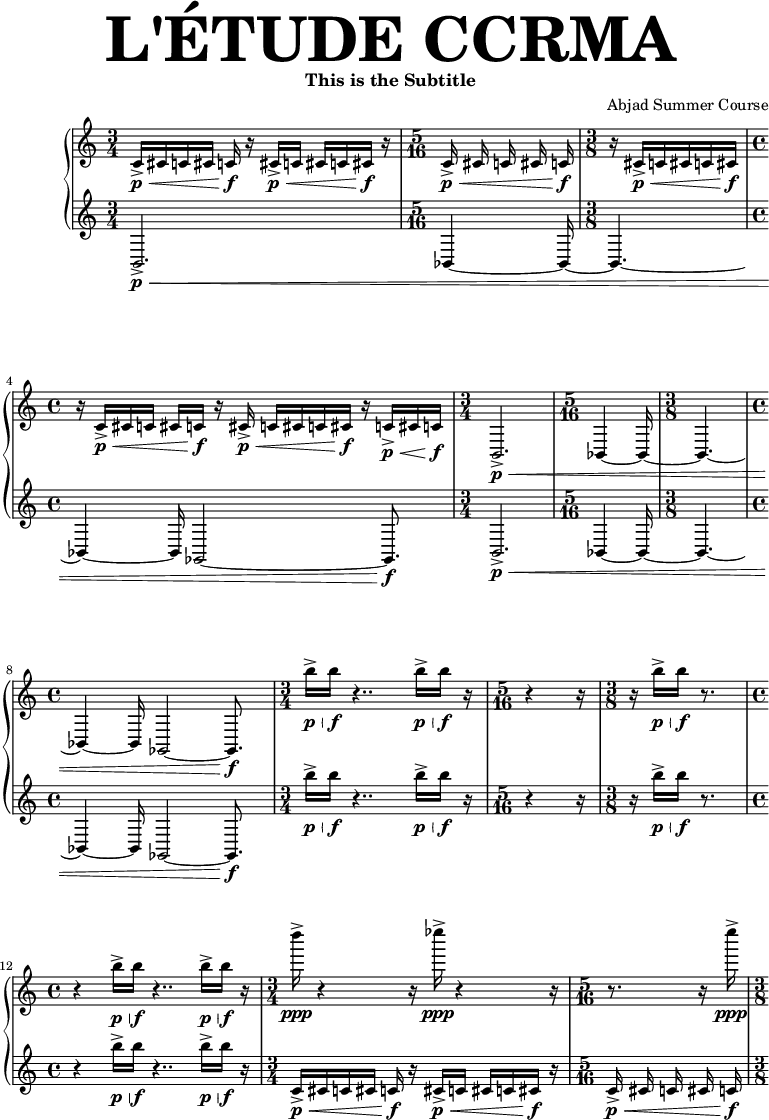

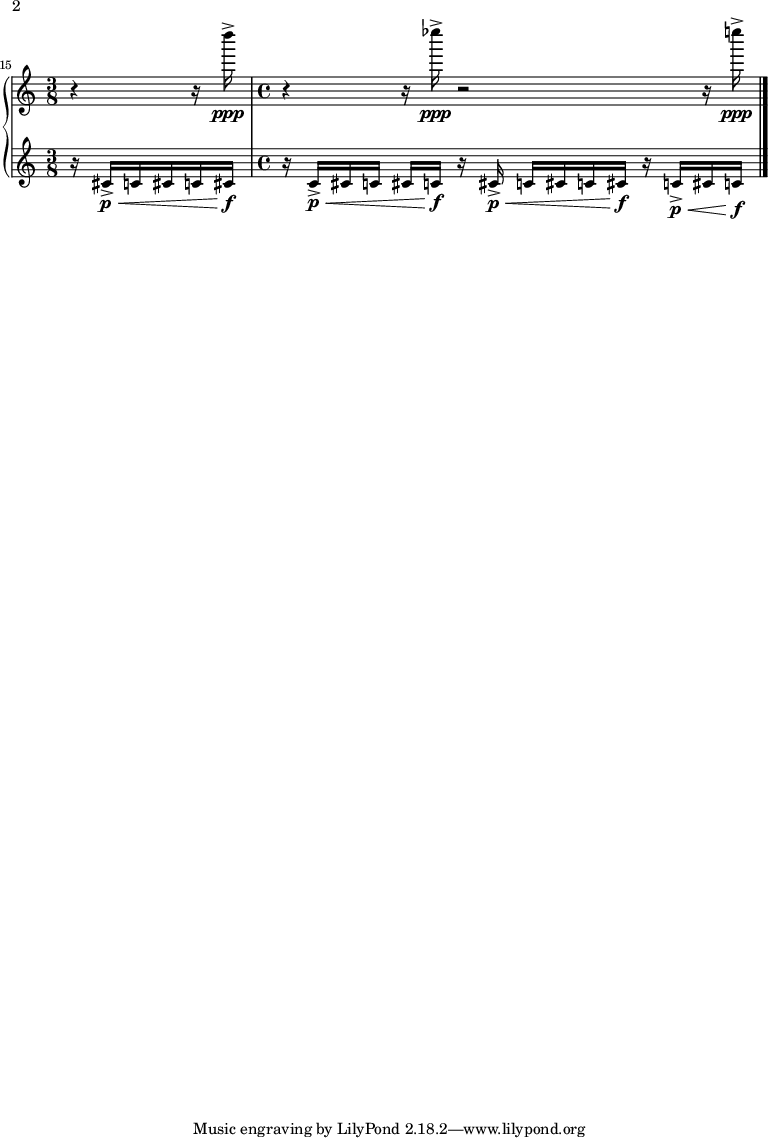

In [31]:
lilypond_file = abjad.LilyPondFile.new(score)
lilypond_file.header_block.composer = 'Abjad Summer Course'
title_markup = abjad.Markup("L'ÉTUDE CCRMA").bold().fontsize(8)
lilypond_file.header_block.title = title_markup
lilypond_file.header_block.subtitle = 'This is the Subtitle'
abjad.show(lilypond_file)

## Conclusion
Hopefully this demonstrates how much can be done with just one class definition and multiple variously configured instances of the same class. In the next notebook, we'll look at one way that multiple custom classes might interact to generate a musical passage.